# Transfer Learning with YAMNET
## Audio Classification with the ESC-50 dataset

This notebook performs audio classification on audio fragments of 5 seconds long

In [2]:
# IMPORT ALL LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import seaborn as sns

import librosa
import librosa.display

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import tensorflow_hub as hub

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Load the data

### ESC-50 dataset

In [3]:
# Set sample rate to work with at 8000

SR = 16000

In [4]:
info = pd.read_csv('/kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/meta/esc50.csv')

In [5]:
info_list = list(info['category'].unique())

labels = {}

for i, label in enumerate(info_list):
        labels[label] = i

NUM_CLASSES = len(labels)

In [6]:
# Create a new empty dictionary
reversed_labels = {}

# Iterate through the key-value pairs in the dictionary
for key, value in labels.items():
  # Add the key-value pair to the new dictionary in the reverse order
  reversed_labels[value] = key

In [7]:
esc50_files = list(info['filename'])

### Load the wav files

In [8]:
ESC50_FOLDER = '/kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/audio'

In [9]:
def wav_data_loader(files, normalization=True):
    
    all_fragments = []
    
    for file in files:
        
        # Load the audio file
        
        AUDIO_FILE = os.path.join(ESC50_FOLDER, file)
        
        sample, sample_rate = librosa.load(AUDIO_FILE, sr=SR)
        
        if normalization==True:
            
            # Normalize the waveform
            sample = librosa.util.normalize(sample)
        
        cat = info[info['filename'] == file]['category'].iloc[0]
        
        sample = (sample, labels[cat])    
    
        all_fragments.append(sample)
    
    return all_fragments

In [10]:
%%time
esc50_wav_dataset = wav_data_loader(esc50_files, normalization=False)

CPU times: user 17.7 s, sys: 1.45 s, total: 19.2 s
Wall time: 46 s


In [11]:
len(esc50_wav_dataset)

2000

## Train-test split

Creating a first train-test split in the original dataset will be useful for correct data augmentation and pre-processing techniques.

In [12]:
X = [wav[0] for wav in esc50_wav_dataset]
y = [wav[1] for wav in esc50_wav_dataset]

X_train_wav, X_test_wav, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train_wav, X_val_wav, y_train, y_val = train_test_split(X_train_wav, y_train, test_size=0.2, stratify=y_train, random_state=42)

## Waveform augmentation

In [13]:
def add_noise(wav_data, noise_factor):

    # Generate noise signal with the same shape as input waveform
    noise = np.random.normal(0, 1, len(wav_data))

    # Scale noise signal with the permissible noise factor value
    noise *= noise_factor

    # Add noise signal to input waveform
    augmented_wav_data = wav_data + noise

    # Normalize the augmented waveform data
    augmented_wav_data = librosa.util.normalize(augmented_wav_data)

    return augmented_wav_data

def time_shift(audio, p):
    """
    Shift audio to the left or right by a random amount.
    """
    # Calculate the length of the audio array
    length = audio.shape[0]

    # Calculate the maximum number of samples to shift
    max_shift = int(length * p)

    # Generate a random shift value
    shift = random.randint(-max_shift, max_shift)

    # Create an empty array with the same shape as the audio array
    shifted_audio = np.zeros_like(audio)

    # Shift the audio by the specified number of samples
    if shift > 0:
      # Shift to the right
        shifted_audio[shift:] = audio[:length-shift]
    else:
        # Shift to the left
        shifted_audio[:length+shift] = audio[-shift:]
    
    if np.sum(shifted_audio) == 0:
        #revert the process if all information was erased
        shifted_audio = audio     

    return shifted_audio

def time_stretching(audio,factor):
    
    wav_time_stch = librosa.effects.time_stretch(audio,rate=factor)
    
    return wav_time_stch[:SR*5]

In [14]:
%%time
''' EXUCUTE THIS CELL TO APPLY DATA AUGMENTATION
Lots of memory required this step could be optimized'''

def augment_wavs(wav_dataset, y):
    
    wav_dataset_augmented = []

    for wav in wav_dataset:
        # Create a copy of the original wav to prevent unwanted side effects
        temp_wav = wav.copy()
        temp_wav = add_noise(temp_wav, 0.025) # We want to use values between 0.005 and 0.04
        temp_wav = time_shift(temp_wav, 0.3)  # We want to use a max shift of 30%
        temp_wav = time_stretching(temp_wav, 0.85)

        wav_dataset_augmented.append(temp_wav)

    # Add original wavs to augmented list
    wav_dataset_augmented.extend(wav_dataset)
    
    y = y + y #each spec is being appended at the bottom of the list

    return wav_dataset_augmented, y

X_train_wav, y_train = augment_wavs(X_train_wav, y_train)

CPU times: user 1min, sys: 556 ms, total: 1min 1s
Wall time: 1min 1s


# Training

In [15]:
# Extract the embeddings with Yamnet

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [16]:
%%time

def extract_embeddings(waveforms):
    embeddings_list = []
    for waveform in waveforms:
        _, embeddings, _ = yamnet_model(waveform)
        embeddings_list.append(np.array(embeddings))
    return embeddings_list

X_train_embeddings = extract_embeddings(X_train_wav)

X_val_embeddings = extract_embeddings(X_val_wav)

X_test_embeddings = extract_embeddings(X_test_wav)

CPU times: user 14.9 s, sys: 1.82 s, total: 16.7 s
Wall time: 19.2 s


In [17]:
X_train_embeddings[0].shape

(10, 1024)

In [18]:
len(X_train_embeddings)

2240

In [19]:
# # TO USE SEPARATED EMBEDDINGS

def split_embeddings_and_labels(X_embeddings, y):
    X_split = []
    y_split = []
    idx = []
    
    for i in range(len(X_embeddings)):
        for j in range(len(X_embeddings[i])):
            X_split.append(X_embeddings[i][j])
            y_split.append(y[i])
            idx.append(i)
    
    return X_split, y_split, idx
    
X_train_embeddings, y_train, index =  split_embeddings_and_labels(X_train_embeddings, y_train)
X_val_embeddings, y_val, index =  split_embeddings_and_labels(X_val_embeddings, y_val)
X_test_embeddings, y_test, index =  split_embeddings_and_labels(X_test_embeddings, y_test)

In [20]:
'''
# TO USE ALL THE EMBEDDINGS FLATTENED

def reshape_data(X_embeddings):
    X_reshaped = []
    for embedding in X_embeddings:
        embedding = embedding.flatten()
        X_reshaped.append(embedding)
    return X_reshaped
    
X_train_embeddings =  reshape_data(X_train_embeddings)
X_val_embeddings =  reshape_data(X_val_embeddings)
X_test_embeddings =  reshape_data(X_test_embeddings)
'''

'\n# TO USE ALL THE EMBEDDINGS FLATTENED\n\ndef reshape_data(X_embeddings):\n    X_reshaped = []\n    for embedding in X_embeddings:\n        embedding = embedding.flatten()\n        X_reshaped.append(embedding)\n    return X_reshaped\n    \nX_train_embeddings =  reshape_data(X_train_embeddings)\nX_val_embeddings =  reshape_data(X_val_embeddings)\nX_test_embeddings =  reshape_data(X_test_embeddings)\n'

In [21]:
X_train_embeddings[0].shape

(1024,)

In [22]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_embeddings[0].shape), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
earlystopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto')

# Define model checkpoint
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)

callbacks = [earlystopping, model_checkpoint]

history = model.fit(np.array(X_train_embeddings), np.array(y_train), epochs=50, batch_size=32, validation_data=(np.array(X_val_embeddings), np.array(y_val)), callbacks=callbacks)

Epoch 1/50
691/700 [============================>.] - ETA: 0s - loss: 2.6129 - accuracy: 0.4101
Epoch 1: val_loss improved from inf to 1.69879, saving model to best_model.h5
700/700 [==============================] - 3s 3ms/step - loss: 2.6046 - accuracy: 0.4116 - val_loss: 1.6988 - val_accuracy: 0.6139
Epoch 2/50
695/700 [============================>.] - ETA: 0s - loss: 2.0702 - accuracy: 0.5004
Epoch 2: val_loss improved from 1.69879 to 1.51311, saving model to best_model.h5
700/700 [==============================] - 2s 3ms/step - loss: 2.0700 - accuracy: 0.5003 - val_loss: 1.5131 - val_accuracy: 0.6368
Epoch 3/50
700/700 [==============================] - ETA: 0s - loss: 1.9467 - accuracy: 0.5204
Epoch 3: val_loss improved from 1.51311 to 1.45971, saving model to best_model.h5
700/700 [==============================] - 2s 3ms/step - loss: 1.9467 - accuracy: 0.5204 - val_loss: 1.4597 - val_accuracy: 0.6354
Epoch 4/50
685/700 [============================>.] - ETA: 0s - loss: 1.8673 

In [23]:
model = load_model('/kaggle/working/best_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                51250     
                                                                 
Total params: 51,250
Trainable params: 51,250
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_embeddings), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

188/188 - 0s - loss: 1.4266 - accuracy: 0.6303 - 448ms/epoch - 2ms/step
Test loss: 1.4265509843826294
Test accuracy: 0.6303333044052124


In [25]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 51250


### Visualization of the training process

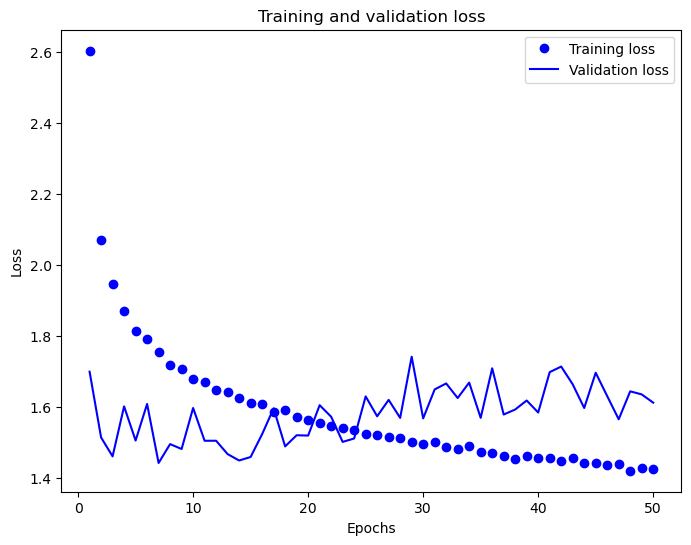

In [26]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

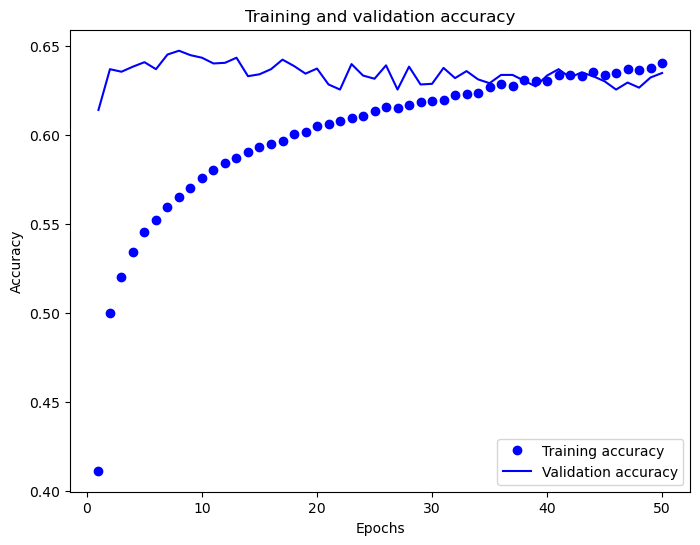

In [27]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
# Save and export the model

model.save('model_esc50_YamNet_al5s.h5')

### Confussion matrix

188/188 [==============================] - 0s 1ms/step


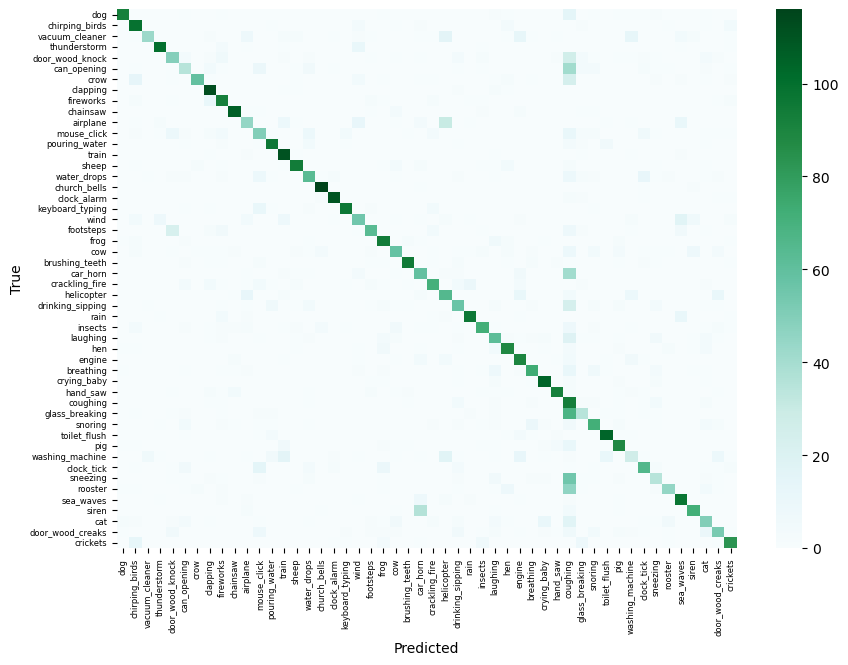

In [36]:
y_true = y_test
y_pred = model.predict(np.array(X_test_embeddings))
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Real evaluation

### Route 1: most common prediction

In [37]:
import pandas as pd

df = pd.DataFrame({
    'idx': index,
    'y_test': y_test,
    'y_pred': y_pred
})

df.head(20)

,idx,y_test,y_pred
0,0,23,23
1,0,23,23
2,0,23,23
3,0,23,23
4,0,23,23
5,0,23,23
6,0,23,23
7,0,23,23
8,0,23,23
9,0,23,23


In [38]:
# Assuming df is your DataFrame

# Group by 'idx' column and take first value of 'y_test' and the mode (most common) value of 'y_pred'
df_grouped = df.groupby('idx').agg({
    'y_test': 'first',
    'y_pred': lambda x: x.mode()[0] if len(x.mode()) > 0 else None
}).reset_index()

df_grouped.head(20)

,idx,y_test,y_pred
0,0,23,23
1,1,6,6
2,2,33,33
3,3,23,23
4,4,43,36
5,5,35,35
6,6,46,46
7,7,25,5
8,8,9,9
9,9,35,35


In [39]:
# Convert 'y_test' column to a numpy array
y_test = df_grouped['y_test'].values

# Convert 'y_pred' column to a numpy array
y_pred = df_grouped['y_pred'].values

# Calculate accuracy
accuracy = np.mean(y_test == y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 75.67%


### Route 2: strongest prediction

In [40]:
y_true = y_test
y_pred = model.predict(np.array(X_test_embeddings))

188/188 [==============================] - 0s 1ms/step


In [34]:
y_pred[9]

array([4.3583917e-04, 9.9186329e-03, 7.5452081e-06, 3.3063054e-05,
       6.3402945e-04, 1.4875508e-03, 1.0673689e-04, 1.8403737e-04,
       3.9819592e-05, 5.4017050e-06, 8.9861584e-05, 3.0951346e-03,
       2.0423965e-03, 5.0199983e-06, 2.0331633e-03, 9.6958414e-05,
       1.0776173e-06, 3.0079598e-05, 1.4578390e-02, 3.4341306e-04,
       1.5817855e-05, 2.3030215e-03, 7.0490663e-05, 7.3617309e-01,
       1.7204589e-05, 1.9018191e-03, 7.1954491e-05, 1.2844983e-03,
       1.1566660e-04, 1.2604578e-02, 3.3617399e-03, 2.2044623e-02,
       1.2079709e-03, 2.2099910e-03, 1.0515412e-03, 7.1505785e-02,
       2.2728662e-03, 3.6122091e-04, 2.4074872e-04, 6.1542058e-05,
       5.2387629e-02, 1.4690578e-04, 3.6027603e-02, 1.1108262e-04,
       1.5126019e-04, 2.3223140e-06, 3.9293798e-05, 1.3157584e-03,
       8.9507159e-03, 6.8230475e-03], dtype=float32)

In [44]:
# Create an empty list to hold the stacked arrays
y_pred_scores = []

# Iterate through array_list in steps of 10
for i in range(0, len(y_pred), 10):
    
    # Select 10 arrays and stack them together
    stacked = np.stack(y_pred[i:i+10])
    
    mean_array = np.mean(stacked, axis=0)
    
    # Append the stacked array to stacked_arrays
    y_pred_scores.append(mean_array)

In [48]:
len(y_test)

600

In [45]:
len(y_pred_scores)

600

In [46]:
y_pred = np.argmax(y_pred_scores, axis=1)

In [49]:
# Calculate accuracy
accuracy = np.mean(y_test_np == y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 82.50%
